In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNetCV

from sklearn.tree import DecisionTreeRegressor
from scipy.stats import binom, beta

In [2]:
ads = pd.read_csv('data/ad.csv')

In [3]:
ads.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [4]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [19]:
ads.drop('device_make', axis = 1, inplace=True)

In [22]:
ads['experiment'] = np.where(ads['experiment'] == 'control', 0, 1)

In [24]:
ads['response'] = ads.yes + ads.no

In [26]:
ads.drop(columns = ['yes', 'no'], axis = 1, inplace=True)

In [29]:
ads.browser.unique()

array(['Chrome Mobile', 'Chrome Mobile WebView', 'Facebook',
       'Mobile Safari', 'Chrome Mobile iOS', 'Samsung Internet',
       'Mobile Safari UI/WKWebView', 'Chrome', 'Opera Mini',
       'Edge Mobile', 'Android', 'Pinterest', 'Opera Mobile',
       'Firefox Mobile', 'Puffin'], dtype=object)

In [31]:
ads['date'] = pd.to_datetime(ads.date)

In [34]:
ads.date.min(), ads.date.max()

(Timestamp('2020-07-03 00:00:00'), Timestamp('2020-07-10 00:00:00'))

In [38]:
ads['dayofweek'] = ads['date'].apply(lambda x: x.dayofweek)

In [40]:
ads.drop('date', axis = 1, inplace = True)

In [46]:
ads.groupby('browser').count()['auction_id']

browser
Android                          1
Chrome                           3
Chrome Mobile                 4554
Chrome Mobile WebView         1489
Chrome Mobile iOS               51
Edge Mobile                      1
Facebook                       764
Firefox Mobile                   1
Mobile Safari                  337
Mobile Safari UI/WKWebView      44
Opera Mini                       1
Opera Mobile                     3
Pinterest                        3
Puffin                           1
Samsung Internet               824
Name: auction_id, dtype: int64

In [51]:
ads['chrome'] = ads['browser'].apply(lambda x: int('Chrome' in x))

In [53]:
ads['samsung'] = ads['browser'].apply(lambda x: int('Samsung' in x))
ads['facebook'] = ads['browser'].apply(lambda x: int('Facebook' in x))
ads['safari'] = ads['browser'].apply(lambda x: int('Safari' in x))

In [55]:
ads.drop('browser', axis = 1, inplace=True)

In [57]:
ads.drop('auction_id', axis = 1, inplace=True)

In [59]:
ads.head()

,experiment,hour,platform_os,response,dayofweek,chrome,samsung,facebook,safari
0,1,8,6,0,4,1,0,0,0
1,1,10,6,0,1,1,0,0,0
2,1,2,6,1,6,1,0,0,0
3,0,15,6,0,4,0,0,1,0
4,0,15,6,0,4,1,0,0,0


### Frequentist Approach

Question: Does the Smart add (experiment = 1) show an improvement in user engagement (response rate)

    Null Hypothesis:
                    Exposure to smart add does NOT  improve response rate
                    Exposure group follows binomial distribution where p  = 0.144
                    
    Alt Hypothesis: Exposure to smart add does improve response rate, p > 0.144
    
    
    Method: Binomial test
    
    Threshold: 0.05

In [99]:
control_response_rate = np.sum(ads[ads.experiment == 0]['response'])/len(ads[ads.experiment == 0])

In [101]:
exposure_response_rate = np.sum(ads[ads.experiment == 1]['response'])/len(ads[ads.experiment == 1])

In [115]:
num_exposure_responses = np.sum(ads[ads.experiment == 1]['response'])

In [102]:
control_response_rate, exposure_response_rate

(0.14394497666421027, 0.16400399400898652)

In [105]:
null_dist = binom(n = len(ads[ads.experiment == 1]), p = control_response_rate)

In [127]:
p_val = 1 - null_dist.cdf(num_exposure_responses)
p_val

0.00017325902905451773

#### Visualize the null hypothesis

In [119]:
num_exposure_responses

657

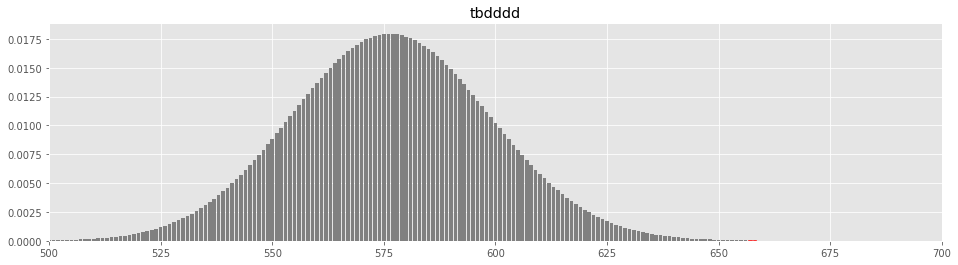

In [129]:

fig, ax = plt.subplots(1, figsize=(16, 4))
bars = ax.bar(range(675), [null_dist.pmf(i) for i in range(675)], align="center", color="grey")
ax.set_xlim(500, 700)
ax.set_title("tbdddd")

for i in range(num_exposure_responses,675):
    bars[i].set_color('red')

### Want at least a 1% lift

Question: Does the Smart add (experiment = 1) show an improvement (>1% lift) in user engagement (response rate)

    Null Hypothesis: There is no difference in response rate from our control group
                    Exposure to smart add does NOT  improve response rate by greater than 1%
                    Exposure group follows binomial distribution where p  = 0.154
                    
    Alt Hypothesis: Exposure to smart add does improve response rate, p > 0.154
    
    
    Method: Binomial test (add some words here)
    
    Threshold: 0.05

In [130]:
null_1pct_lift = control_response_rate + 0.01
null_1pct_lift

0.15394497666421028

In [131]:
null_dist_1pct = binom(n = len(ads[ads.experiment == 1]), p = null_1pct_lift)

In [133]:
pval_1pct =  1 - null_dist_1pct.cdf(num_exposure_responses)
pval_1pct

0.03792092332560393

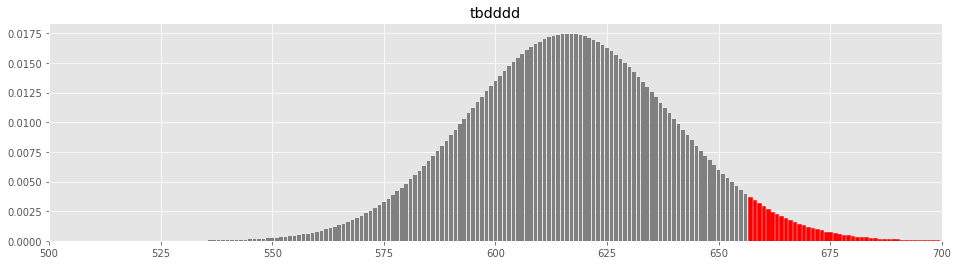

In [136]:
fig, ax = plt.subplots(1, figsize=(16, 4))
bars = ax.bar(range(700), [null_dist_1pct.pmf(i) for i in range(700)], align="center", color="grey")
ax.set_xlim(500, 700)
ax.set_title("tbdddd")

for i in range(num_exposure_responses,700):
    bars[i].set_color('red')

### Bayesian Approach

In [150]:
ctrl_alpha = len(ads[(ads.experiment == 0) & (ads.response == 1)])
ctrl_beta = len(ads[(ads.experiment == 0) & (ads.response == 0)])

exp_alpha = len(ads[(ads.experiment == 1) & (ads.response == 1)])
exp_beta = len(ads[(ads.experiment == 1) & (ads.response == 0)])

In [151]:
ctrl_alpha, ctrl_beta, exp_alpha, exp_beta

(586, 3485, 657, 3349)

In [152]:
ctrl_dist = beta(ctrl_alpha, ctrl_beta)
exp_dist = beta(exp_alpha, exp_beta)

In [172]:
ctrl_cred_int_low, null_cred_int_high = ctrl_dist.ppf([.025, .975])

exp_cred_int_low, exp_cred_int_high = exp_dist.ppf([.025, .975])



# plt.vlines(dist_B.ppf([.025, .975]), ymin = 0, ymax = dist_B.pdf(x).max(), linestyles='dotted')

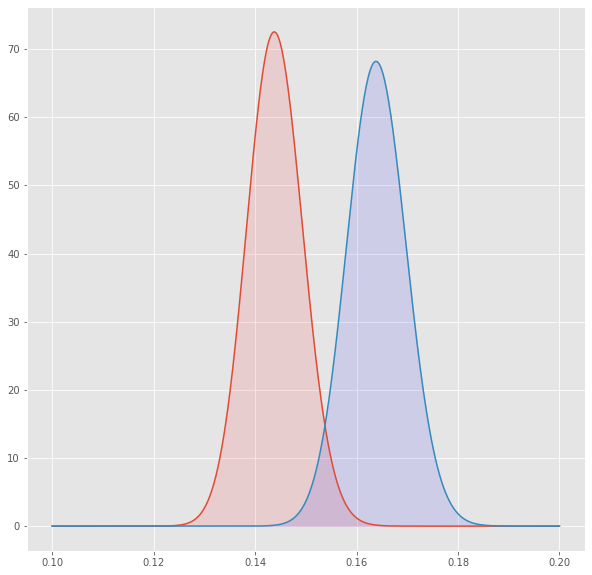

In [177]:
x = np.linspace(.1, .2, 500)

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(x, ctrl_dist.pdf(x))
ax.fill_between(x, 0, ctrl_dist.pdf(x), color = 'r', alpha = 0.1)

'''

ax.axvline(x = null_cred_int_low, linestyle = 'dashed', color = 'r', label = 'control: 95% credible interval')
ax.axvline(x = null_cred_int_high, linestyle = 'dashed', color = 'r')

ax.axvline(x = exp_cred_int_low, linestyle = 'dashed', color = 'b', label = 'exposure: 95% credible interval')
ax.axvline(x = exp_cred_int_high, linestyle = 'dashed', color = 'b')


'''


ax.plot(x, exp_dist.pdf(x))
ax.fill_between(x, 0, exp_dist.pdf(x), color = 'b', alpha = 0.1)

In [164]:

#run simulations: how often is the exposure response rate > control

num_simulations = 100_000

simulated_A = ctrl_dist.rvs(num_simulations)
simulated_B = exp_dist.rvs(num_simulations)

print((simulated_B > simulated_A).mean())

0.99402


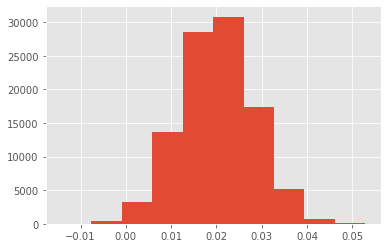

In [176]:
sim_diffs = simulated_B - simulated_A
plt.hist(sim_diffs);


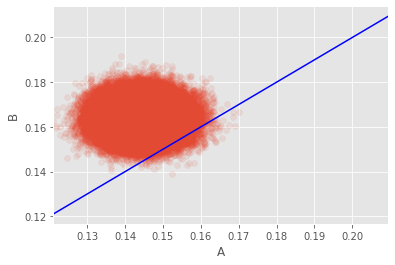

In [174]:
plt.scatter(simulated_A, simulated_B, alpha = .1);
plt.xlim(plt.ylim())
plt.xlabel('A'), plt.ylabel('B')
plt.plot(plt.xlim(), plt.xlim(), color = 'blue');

In [1]:
#to do: calculate credible intervals

#### what's the probability of site b being 1% better than a?

In [178]:
print((simulated_B > simulated_A + .01).mean())

0.89599


#### what about 2%?

In [179]:
print((simulated_B > simulated_A + .02).mean())

0.50513
